# Wuzzuf Job Market Analysis - Experience Requirements Analysis

This notebook analyzes the distribution of experience level requirements in the Wuzzuf job market data.

## Business Question:
**What is the distribution of experience level requirements across job postings?**

This analysis examines how job postings are distributed across Entry (0-2 years), Mid (3-5 years), and Senior (6+ years) experience levels, providing insights into market demand patterns and hiring trends across industries and roles.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
from pathlib import Path

# Add sql directory to path for database utilities
sys.path.append('../sql')
from database_setup import DatabaseManager

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create charts directory if it doesn't exist
charts_dir = Path('../assets/charts')
charts_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Charts will be saved to: {charts_dir.absolute()}")

Libraries imported successfully
Charts will be saved to: c:\Users\hp\Downloads\wuzuf-analysis\notebooks\..\assets\charts


In [2]:
# Initialize database connection
print("Connecting to PostgreSQL database...")

try:
    db_manager = DatabaseManager()
    engine = db_manager.get_engine()
    
    # Test connection
    status = db_manager.test_connection()
    print(f"✅ Connected to database: {status['database']}")
    print(f"📊 Tables available: {status['table_count']}")
    
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Please ensure PostgreSQL is running and database is set up correctly")
    raise

2025-08-14 22:57:29,968 - INFO - Database connection established successfully


Connecting to PostgreSQL database...
✅ Connected to database: wuzzuf
📊 Tables available: 6


## Analysis: Experience Level Distribution

This analysis examines the distribution of job postings across different experience levels and provides insights into market demand patterns.

In [3]:
# SQL query for experience level distribution with percentages
experience_distribution_query = """
SELECT 
    experience_level,
    COUNT(*) as posting_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM jobs WHERE experience_level IS NOT NULL), 2) as percentage
FROM jobs 
WHERE experience_level IS NOT NULL 
    AND experience_level != ''
GROUP BY experience_level 
ORDER BY posting_count DESC;
"""

# Execute query and display results
print("🔍 Analysis: Experience Level Distribution")
print("=" * 50)

experience_dist_df = pd.read_sql(experience_distribution_query, engine)
print("📊 Experience Level Distribution:")
print(experience_dist_df.to_string(index=False))

# Store for visualization
experience_summary = experience_dist_df.head(10)  # Limit to max 10 rows as per requirements

🔍 Analysis: Experience Level Distribution
📊 Experience Level Distribution:
experience_level  posting_count  percentage
             Mid          12884       51.30
          Senior           7005       27.89
           Entry           5225       20.81


In [4]:
# Experience analysis by industry breakdown
print("\n" + "-" * 50)
print("🏢 Experience Distribution by Industry:")

experience_by_industry_query = """
SELECT 
    c.industry,
    j.experience_level,
    COUNT(*) as posting_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY c.industry), 2) as percentage_within_industry
FROM jobs j
JOIN companies c ON j.company_id = c.company_id
WHERE j.experience_level IS NOT NULL 
    AND j.experience_level != ''
    AND c.industry IS NOT NULL 
    AND c.industry != ''
GROUP BY c.industry, j.experience_level
ORDER BY c.industry, posting_count DESC
LIMIT 30;
"""

experience_by_industry_df = pd.read_sql(experience_by_industry_query, engine)
print(experience_by_industry_df.to_string(index=False))


--------------------------------------------------
🏢 Experience Distribution by Industry:
                     industry experience_level  posting_count  percentage_within_industry
              2 school alumni              Mid              4                       80.00
              2 school alumni           Senior              1                       20.00
                   accounting              Mid             10                       76.92
                   accounting           Senior              3                       23.08
            airlines/aviation            Entry              3                       60.00
            airlines/aviation           Senior              2                       40.00
            apparel & fashion              Mid             25                       59.52
            apparel & fashion            Entry             12                       28.57
            apparel & fashion           Senior              5                       11.90
      arc

In [5]:
# Experience analysis by role breakdown
print("\n" + "-" * 50)
print("👔 Experience Distribution by Top Job Roles:")

experience_by_role_query = """
WITH top_roles AS (
    SELECT job_title
    FROM jobs 
    WHERE job_title IS NOT NULL AND job_title != ''
    GROUP BY job_title
    ORDER BY COUNT(*) DESC
    LIMIT 5
)
SELECT 
    j.job_title,
    j.experience_level,
    COUNT(*) as posting_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY j.job_title), 2) as percentage_within_role
FROM jobs j
JOIN top_roles tr ON j.job_title = tr.job_title
WHERE j.experience_level IS NOT NULL 
    AND j.experience_level != ''
GROUP BY j.job_title, j.experience_level
ORDER BY j.job_title, posting_count DESC;
"""

experience_by_role_df = pd.read_sql(experience_by_role_query, engine)
print(experience_by_role_df.to_string(index=False))


--------------------------------------------------
👔 Experience Distribution by Top Job Roles:
        job_title experience_level  posting_count  percentage_within_role
 business analyst              Mid           1306                   65.01
 business analyst           Senior            471                   23.44
 business analyst            Entry            232                   11.55
    data engineer              Mid           1617                   46.71
    data engineer           Senior           1221                   35.27
    data engineer            Entry            624                   18.02
   data scientist              Mid            929                   46.47
   data scientist           Senior            666                   33.32
   data scientist            Entry            404                   20.21
        developer              Mid            641                   42.68
        developer           Senior            530                   35.29
        develope


📈 Creating Experience Distribution Visualization...
✅ Chart saved to: ..\assets\charts\experience_distribution.png


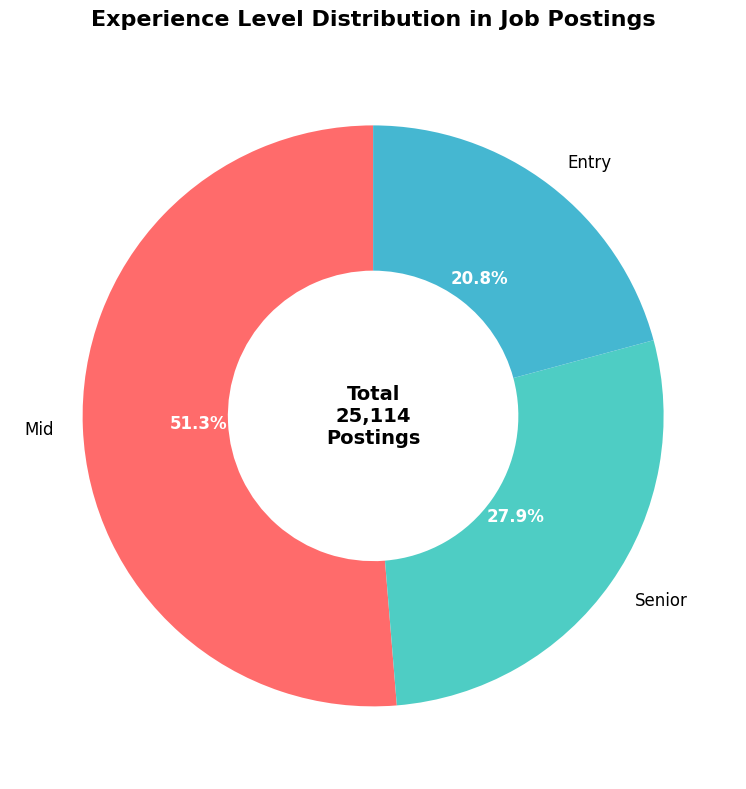

In [6]:
# Create donut chart visualization for experience distribution
print("\n" + "=" * 50)
print("📈 Creating Experience Distribution Visualization...")

# Prepare data for donut chart
fig, ax = plt.subplots(figsize=(10, 8))

# Create donut chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
wedges, texts, autotexts = ax.pie(
    experience_summary['posting_count'], 
    labels=experience_summary['experience_level'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(experience_summary)],
    wedgeprops=dict(width=0.5),  # Creates donut effect
    textprops={'fontsize': 12}
)

# Customize the chart
ax.set_title('Experience Level Distribution in Job Postings', 
             fontsize=16, fontweight='bold', pad=20)

# Add center text
total_postings = experience_summary['posting_count'].sum()
ax.text(0, 0, f'Total\n{total_postings:,}\nPostings', 
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()

# Save the chart
chart_path = charts_dir / 'experience_distribution.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Chart saved to: {chart_path}")

plt.show()

In [7]:
# Generate business insights
print("\n" + "=" * 50)
print("💡 Business Insights - Experience Requirements Analysis")
print("=" * 50)

# Calculate key metrics
total_jobs = experience_summary['posting_count'].sum()
top_experience_level = experience_summary.iloc[0]
entry_level_jobs = experience_summary[experience_summary['experience_level'] == 'Entry']['posting_count'].sum() if 'Entry' in experience_summary['experience_level'].values else 0
senior_level_jobs = experience_summary[experience_summary['experience_level'] == 'Senior']['posting_count'].sum() if 'Senior' in experience_summary['experience_level'].values else 0

insights = []

# Insight 1: Most common experience level
insights.append(f"The {top_experience_level['experience_level']} level dominates the job market with {top_experience_level['posting_count']:,} postings ({top_experience_level['percentage']:.1f}% of all jobs), indicating strong demand for professionals at this experience tier.")

# Insight 2: Entry vs Senior comparison
if entry_level_jobs > 0 and senior_level_jobs > 0:
    ratio = entry_level_jobs / senior_level_jobs
    if ratio > 1:
        insights.append(f"Entry-level opportunities ({entry_level_jobs:,} jobs) outnumber senior positions ({senior_level_jobs:,} jobs) by {ratio:.1f}x, suggesting a market focused on building junior talent pipelines.")
    else:
        insights.append(f"Senior positions ({senior_level_jobs:,} jobs) outnumber entry-level opportunities ({entry_level_jobs:,} jobs) by {1/ratio:.1f}x, indicating higher demand for experienced professionals.")

# Insight 3: Market distribution pattern
if len(experience_summary) >= 2:
    top_two_percentage = experience_summary.head(2)['percentage'].sum()
    insights.append(f"The top two experience levels account for {top_two_percentage:.1f}% of all job postings, showing concentrated demand in specific experience segments rather than even distribution across all levels.")

# Print insights
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print("\n" + "=" * 50)
print("✅ Experience Requirements Analysis Complete")
print("=" * 50)


💡 Business Insights - Experience Requirements Analysis
1. The Mid level dominates the job market with 12,884 postings (51.3% of all jobs), indicating strong demand for professionals at this experience tier.
2. Senior positions (7,005 jobs) outnumber entry-level opportunities (5,225 jobs) by 1.3x, indicating higher demand for experienced professionals.
3. The top two experience levels account for 79.2% of all job postings, showing concentrated demand in specific experience segments rather than even distribution across all levels.

✅ Experience Requirements Analysis Complete
